# Soccer Science

## Setup

### Import the Data

Import all necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import scipy
import numpy as np
import datetime
import xgboost as xgb
import pickle

from pivottablejs import pivot_ui
from IPython.display import display
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score


Load the data. Note that the **date is first** (British format)

In [2]:
df_raw = pd.read_csv("..//Data/2015_2020_William_hill.csv", parse_dates=["Date"], dayfirst=True)
df_names = pd.read_csv("..//Data/teams_to_numbers_MD.csv")
df_names1516 = pd.read_csv("..//Data/teams_to_numbers1516_MD.csv")
df_names1617 = pd.read_csv("..//Data/teams_to_numbers1617_MD.csv")
df_names1718 = pd.read_csv("..//Data/teams_to_numbers1718_MD.csv")
df_names1819 = pd.read_csv("..//Data/teams_to_numbers1819_MD.csv")
df_names1920 = pd.read_csv("..//Data/teams_to_numbers1920_MD.csv")

### Extract Year and Month

Look at **all** data using info, describe and head.
We can check for NAN / null values in info.

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Add more information to the datetime feature

In [4]:
df_raw['year'] = pd.DatetimeIndex(df_raw['Date']).year
df_raw['month'] = pd.DatetimeIndex(df_raw['Date']).month

In [5]:
df_raw.head(10)

,Date,HomeTeam,AwayTeam,outcome_by_HOME,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month
0,2015-08-08,Bournemouth,Aston Villa,A,1.91,3.5,4.00,2015,8
1,2015-08-08,Chelsea,Swansea,D,1.40,4.0,10.00,2015,8
2,2015-08-08,Everton,Watford,D,1.73,3.5,5.00,2015,8
3,2015-08-08,Leicester,Sunderland,H,2.00,3.1,2.70,2015,8
4,2015-08-08,Man United,Tottenham,H,1.62,3.6,6.00,2015,8
5,2015-08-08,Norwich,Crystal Palace,A,2.60,3.1,2.88,2015,8
6,2015-08-09,Arsenal,West Ham,A,1.30,5.0,11.00,2015,8
7,2015-08-09,Newcastle,Southampton,D,2.70,3.1,2.70,2015,8
8,2015-08-09,Stoke,Liverpool,A,3.30,3.1,2.30,2015,8
9,2015-08-10,West Brom,Man City,A,5.50,3.5,1.70,2015,8


In [6]:
df_raw.describe()

,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month
count,1770.000000,1770.000000,1770.000000,1900.000000,1900.000000
mean,2.942164,4.031136,4.996678,2017.481053,6.751579
std,2.296751,1.336752,4.637151,1.489708,3.945571
min,1.050000,2.800000,1.120000,2015.000000,1.000000
25%,1.670000,3.250000,2.350000,2016.000000,3.000000
50%,2.250000,3.500000,3.300000,2017.000000,8.000000
75%,3.100000,4.200000,5.500000,2019.000000,11.000000
max,21.000000,13.000000,46.000000,2020.000000,12.000000


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 9 columns):
Date                        1900 non-null datetime64[ns]
HomeTeam                    1900 non-null object
AwayTeam                    1900 non-null object
outcome_by_HOME             1770 non-null object
AVERAGE_ODD_WIN             1770 non-null float64
AVERAGE_ODD_DRAW            1770 non-null float64
AVERAGE_ODD_OPPONENT_WIN    1770 non-null float64
year                        1900 non-null int64
month                       1900 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 133.7+ KB


### Make Catagorical Features Numerical and add Team Information

There are no null items, but there are strings which need to be turned into catagorical data: team name and outcome. And we want the "last game" number to be consistent with the W, D, L of the "outcome"

In [8]:
df_raw['outcome_by_HOME'] = df_raw.outcome_by_HOME.astype('category')

In [9]:
df_raw = df_raw.replace('H', 2)
df_raw = df_raw.replace('D', 1)
df_raw = df_raw.replace('A', 0)

In [10]:
df_num = df_names.merge(df_raw, left_on='Team', right_on='HomeTeam');
df_num = df_num.drop(['Team'], axis=1)



In [11]:
df_num.rename(columns = {'Av_Salary_Club':'H_Av_Salary_Club',
                         'Draw':'H_Draw',
                         'Goals_For':'H_Goals_For',
                         'Goal_Difference':'H_Goal_Difference'},
              inplace = True)

In [12]:
df_num.rename(columns = {'Team_Number':'H_Team_number'}, inplace = True)

In [13]:
df_num2 = df_names.merge(df_num, left_on='Team', right_on='AwayTeam');
df_num2 = df_num2.drop(['Team'], axis=1)

In [14]:
df_num2.rename(columns = {'Av_Salary_Club':'A_Av_Salary_Club',
                         'Draw':'A_Draw',
                         'Goals_For':'A_Goals_For',
                         'Goal_Difference':'A_Goal_Difference'},
              inplace = True)

In [15]:
df_num2.rename(columns = {'Team_Number':'A_Team_number'}, inplace = True)

In [16]:
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 1899
Data columns (total 19 columns):
A_Team_number               1900 non-null int64
A_Av_Salary_Club            1900 non-null float64
A_Draw                      1900 non-null int64
A_Goals_For                 1900 non-null int64
A_Goal_Difference           1900 non-null int64
H_Team_number               1900 non-null int64
H_Av_Salary_Club            1900 non-null float64
H_Draw                      1900 non-null int64
H_Goals_For                 1900 non-null int64
H_Goal_Difference           1900 non-null int64
Date                        1900 non-null datetime64[ns]
HomeTeam                    1900 non-null object
AwayTeam                    1900 non-null object
outcome_by_HOME             1770 non-null float64
AVERAGE_ODD_WIN             1770 non-null float64
AVERAGE_ODD_DRAW            1770 non-null float64
AVERAGE_ODD_OPPONENT_WIN    1770 non-null float64
year                        1900 non-null int64
month 

In [17]:
df_num2['RandomNumber'] = np.random.randint(1, df_num2.shape[0], df_num2.shape[0])


In [18]:
df_num2 = df_num2.sort_values(by=['Date'])
df_num2 = df_num2.reset_index(drop=True)


In [19]:
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 20 columns):
A_Team_number               1900 non-null int64
A_Av_Salary_Club            1900 non-null float64
A_Draw                      1900 non-null int64
A_Goals_For                 1900 non-null int64
A_Goal_Difference           1900 non-null int64
H_Team_number               1900 non-null int64
H_Av_Salary_Club            1900 non-null float64
H_Draw                      1900 non-null int64
H_Goals_For                 1900 non-null int64
H_Goal_Difference           1900 non-null int64
Date                        1900 non-null datetime64[ns]
HomeTeam                    1900 non-null object
AwayTeam                    1900 non-null object
outcome_by_HOME             1770 non-null float64
AVERAGE_ODD_WIN             1770 non-null float64
AVERAGE_ODD_DRAW            1770 non-null float64
AVERAGE_ODD_OPPONENT_WIN    1770 non-null float64
year                        1900 non-null int64
month 

In [20]:
df_num2.fillna(value=0, inplace=True)
df_num2.tail()

,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,Date,HomeTeam,AwayTeam,outcome_by_HOME,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
1895,19,0.65,92,365,-145,15,5.99,196,1374,399,2020-05-17,Man City,Norwich,0.0,0.0,0.0,0.0,2020,5,1763
1896,29,1.76,49,203,-124,7,5.02,257,1770,768,2020-05-17,Chelsea,Wolves,0.0,0.0,0.0,0.0,2020,5,662
1897,26,1.78,51,240,-137,1,4.85,260,1845,832,2020-05-17,Arsenal,Watford,0.0,0.0,0.0,0.0,2020,5,296
1898,3,1.99,36,201,-64,9,3.25,296,1357,46,2020-05-17,Everton,Bournemouth,0.0,0.0,0.0,0.0,2020,5,37
1899,16,6.53,224,1989,1060,13,2.71,136,623,-95,2020-05-17,Leicester,Man United,0.0,0.0,0.0,0.0,2020,5,897


### Split Data into Seasons / Years, Add Seasonal Information

In [21]:
df = df_num2

In [22]:
df_2015B = df[(df["year"]==2015) & (df["month"]>=7)]
df_2016A = df[(df["year"]==2016) & (df["month"]<7)]
df_2016B = df[(df["year"]==2016) & (df["month"]>=7)]
df_2017A = df[(df["year"]==2017) & (df["month"]<7)]
df_2017B = df[(df["year"]==2017) & (df["month"]>=7)]
df_2018A = df[(df["year"]==2018) & (df["month"]<7)]
df_2018B = df[(df["year"]==2018) & (df["month"]>=7)]
df_2019A = df[(df["year"]==2019) & (df["month"]<7)]
df_2019B = df[(df["year"]==2019) & (df["month"]>=7)]
df_2020A = df[(df["year"]==2020) & (df["month"]<7)]

In [23]:
df_15B16A = pd.concat([df_2015B, df_2016A], sort=False)
df_16B17A = pd.concat([df_2016B, df_2017A], sort=False)
df_17B18A = pd.concat([df_2017B, df_2018A], sort=False)
df_18B19A = pd.concat([df_2018B, df_2019A], sort=False)
df_19B20A = pd.concat([df_2019B, df_2020A], sort=False)


In [24]:
df_15B16A_sal = df_names1516.merge(df_15B16A, left_on='Team_Number', right_on='H_Team_number');
df_15B16A_sal = df_15B16A_sal.drop(['Team_Number', 'Team'], axis=1)
df_16B17A_sal = df_names1617.merge(df_16B17A, left_on='Team_Number', right_on='H_Team_number');
df_16B17A_sal = df_16B17A_sal.drop(['Team_Number', 'Team'], axis=1)
df_17B18A_sal = df_names1718.merge(df_17B18A, left_on='Team_Number', right_on='H_Team_number');
df_17B18A_sal = df_17B18A_sal.drop(['Team_Number', 'Team'], axis=1)
df_18B19A_sal = df_names1819.merge(df_18B19A, left_on='Team_Number', right_on='H_Team_number');
df_18B19A_sal = df_18B19A_sal.drop(['Team_Number', 'Team'], axis=1)
df_19B20A_sal = df_names1920.merge(df_19B20A, left_on='Team_Number', right_on='H_Team_number');
df_19B20A_sal = df_19B20A_sal.drop(['Team_Number', 'Team'], axis=1)

In [25]:
df_15B16A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_16B17A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_17B18A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_18B19A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_19B20A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)


In [26]:
df_15B16A_sal2 = df_names1516.merge(df_15B16A_sal, left_on='Team_Number', right_on='A_Team_number');
df_15B16A_sal2 = df_15B16A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_16B17A_sal2 = df_names1617.merge(df_16B17A_sal, left_on='Team_Number', right_on='A_Team_number');
df_16B17A_sal2 = df_16B17A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_17B18A_sal2 = df_names1718.merge(df_17B18A_sal, left_on='Team_Number', right_on='A_Team_number');
df_17B18A_sal2 = df_17B18A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_18B19A_sal2 = df_names1819.merge(df_18B19A_sal, left_on='Team_Number', right_on='A_Team_number');
df_18B19A_sal2 = df_18B19A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_19B20A_sal2 = df_names1920.merge(df_19B20A_sal, left_on='Team_Number', right_on='A_Team_number');
df_19B20A_sal2 = df_19B20A_sal2.drop(['Team_Number', 'Team'], axis=1)

In [27]:
df_15B16A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_16B17A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_17B18A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_18B19A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_19B20A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

In [28]:
df_15B16A_sal2 = df_15B16A_sal2.sort_values(by=['Date'])
df_15B16A_sal2 = df_15B16A_sal2.reset_index(drop=True)

df_16B17A_sal2 = df_16B17A_sal2.sort_values(by=['Date'])
df_16B17A_sal2 = df_16B17A_sal2.reset_index(drop=True)

df_17B18A_sal2 = df_17B18A_sal2.sort_values(by=['Date'])
df_17B18A_sal2 = df_17B18A_sal2.reset_index(drop=True)

df_18B19A_sal2 = df_18B19A_sal2.sort_values(by=['Date'])
df_18B19A_sal2 = df_18B19A_sal2.reset_index(drop=True)

df_19B20A_sal2 = df_19B20A_sal2.sort_values(by=['Date'])
df_19B20A_sal2 = df_19B20A_sal2.reset_index(drop=True)


In [29]:
df_15B161718A_sal2 = pd.concat([df_15B16A_sal2, df_16B17A_sal2, df_17B18A_sal2], sort=False)
df_15B161718A_sal2 = df_15B161718A_sal2.sort_values(by=['Date'])
df_15B161718A_sal2 = df_15B161718A_sal2.reset_index(drop=True)

In [30]:
df_19B20A_sal2_test = df_19B20A_sal2.iloc[0:250]

In [31]:
y_19B20A_output = df_19B20A_sal2.outcome_by_HOME
df_19B20A_output = df_19B20A_sal2.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)


In [32]:
y_15B161718A = df_15B161718A_sal2.outcome_by_HOME
y_18B19A = df_18B19A_sal2.outcome_by_HOME
y_19B20A = df_19B20A_sal2_test.outcome_by_HOME
df_15B161718A = df_15B161718A_sal2.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)
df_18B19A = df_18B19A_sal2.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)
df_19B20A = df_19B20A_sal2_test.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)



### Define Training/Valid/Test Datasets

This is our training data set (2015/2016, 2016/2017, 2017/2018 seasons)

In [33]:
X_train = df_15B161718A
y_train = y_15B161718A

In [34]:
df_19B20A_sal2_test.tail()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,Date,HomeTeam,AwayTeam,outcome_by_HOME,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
245,0,0,0,0,0,14,6,56,-14,45,2,1.30,275,1117,-69,3,1.99,36,201,-64,2020-02-01,Bournemouth,Aston Villa,2.0,2.15,3.50,3.40,2020,2,1601
246,0,0,0,0,0,12,7,51,-2,49,20,0.62,36,128,-40,8,2.76,96,425,-139,2020-02-01,Crystal Palace,Sheffield United,0.0,3.10,3.10,2.50,2020,2,701
247,16,12,45,-20,39,2,7,89,67,97,21,2.67,214,937,-150,14,4.86,262,1774,728,2020-02-01,Liverpool,Southampton,2.0,1.27,5.80,11.00,2020,2,904
248,5,7,73,22,70,15,7,45,-23,40,1,4.85,260,1845,832,5,1.60,44,190,-107,2020-02-02,Burnley,Arsenal,1.0,3.75,3.50,2.00,2020,2,1
249,1,2,95,72,98,4,2,67,28,71,15,5.99,196,1374,399,25,3.52,257,1547,241,2020-02-02,Tottenham,Man City,2.0,5.80,4.33,1.55,2020,2,1326


df_18B19A = validation data; df_19B20A = test data (with y_18B19A and y_19B20A being the corresponding results)

In [35]:
X_valid = df_18B19A
y_valid = y_18B19A
X_test = df_19B20A
y_test = y_19B20A

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. You can construct DMatrix from numpy.arrays

In [36]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [37]:
y_test.tail()

245    2.0
246    0.0
247    2.0
248    1.0
249    2.0
Name: outcome_by_HOME, dtype: float64

In [38]:
X_test.tail()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
245,0,0,0,0,0,14,6,56,-14,45,2,1.30,275,1117,-69,3,1.99,36,201,-64,2.15,3.50,3.40,2020,2,1601
246,0,0,0,0,0,12,7,51,-2,49,20,0.62,36,128,-40,8,2.76,96,425,-139,3.10,3.10,2.50,2020,2,701
247,16,12,45,-20,39,2,7,89,67,97,21,2.67,214,937,-150,14,4.86,262,1774,728,1.27,5.80,11.00,2020,2,904
248,5,7,73,22,70,15,7,45,-23,40,1,4.85,260,1845,832,5,1.60,44,190,-107,3.75,3.50,2.00,2020,2,1
249,1,2,95,72,98,4,2,67,28,71,15,5.99,196,1374,399,25,3.52,257,1547,241,5.80,4.33,1.55,2020,2,1326


## Modelling with RF and Log Reg and Parameter Tuning

### Hyperparameter Optimization Random Forest: Grid Search

In [39]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(clf, X_train, y_train, X_valid, y_valid):
    res = [rmse(clf.predict(X_train), y_train),
           rmse(clf.predict(X_valid), y_valid),
           clf.score(X_train, y_train), clf.score(X_valid, y_valid)]
    if hasattr(clf, 'oob_score_'): res.append(clf.oob_score_)
    print(res)

In [40]:
X_valid.head()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
0,9,11,56,-4,47,2,6,68,40,81,13,2.71,136,623,-95,16,6.53,224,1989,1060,1.57,3.8,6.00,2018,8,1115
1,0,0,0,0,0,12,11,45,-16,44,6,0.96,13,66,-77,3,1.99,36,201,-64,1.91,3.5,4.00,2018,8,719
2,3,8,74,38,77,10,8,39,-8,44,25,3.52,257,1547,241,18,1.65,234,1249,14,3.80,3.2,2.05,2018,8,479
3,8,10,44,-14,49,0,0,0,0,0,9,3.25,296,1357,46,29,1.76,49,203,-124,2.30,3.2,3.20,2018,8,766
4,11,11,45,-10,44,0,0,0,0,0,8,2.76,96,425,-139,10,1.73,141,604,-174,2.45,3.3,2.80,2018,8,1715


In [41]:
clf_default = RandomForestClassifier(random_state=1)
clf_default.fit(X_train, y_train)
print_score(clf_default, X_train, y_train, X_valid, y_valid)

[0.0, 0.9933992677987828, 1.0, 0.5578947368421052]


In [42]:
forest = RandomForestClassifier(random_state=1)

n_estimators = [50, 100, 150]
max_depth = [1, 5, 10, 15, 20, 25]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 6, 12, 18, 24] 
bootstrap = ['False', 'True'] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              bootstrap = bootstrap)

gridF = GridSearchCV(forest, hyperF, verbose = 1, cv=4, n_jobs = -1, scoring='accuracy')
bestF = gridF.fit(X_train, y_train)

Fitting 4 folds for each of 900 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  3.8min finished


In [43]:
print(f'Best: {bestF.best_score_} using {bestF.best_params_}','\n')



Best: 0.5385964912280702 using {'bootstrap': 'False', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 



In [44]:
clf = RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, min_samples_leaf=12, min_samples_split=3, n_estimators=100, bootstrap='False')
clf.fit(X_train, y_train)
print_score(clf, X_train, y_train, X_valid, y_valid)



[0.9403246919632545, 1.0234101919819987, 0.6026315789473684, 0.5842105263157895]


### Logistic Regression Parameter Tuning

In [45]:
clf_LR_default = LogisticRegression(random_state=1).fit(X_train, y_train)
print(clf_LR_default.score(X_train, y_train))

predictions = clf_LR_default.predict(X_valid)
print(accuracy_score(y_valid, predictions))


0.5350877192982456
0.5842105263157895


/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'sag']
c_values = [100, 10, 1.0, 0.1, 0.01]
multi_class= ['multinomial', 'ovr']

# define grid search
grid = dict(solver=solvers,C=c_values, multi_class=multi_class)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridg

Best: 0.528655 using {'C': 0.1, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.519883 (0.020947) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.519298 (0.018400) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
0.522515 (0.018481) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'sag'}
0.526023 (0.023989) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.511696 (0.018668) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
0.525731 (0.017239) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'sag'}
0.519883 (0.020947) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.518713 (0.017824) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
0.521930 (0.018239) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'sag'}
0.526316 (0.024603) with: {'C': 10, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.516082 (0.017157) with: {'C': 10, 'multi_class': 'ovr', 'solver': 'lbfgs'}
0.525439 (0.

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastro

In [47]:
clf_LG = LogisticRegression(random_state=1, multi_class='ovr', solver='newton-cg', C=1.0).fit(X_train, y_train)
print(clf_LG.score(X_train, y_train))

predictions = clf_LG.predict(X_valid)
print(accuracy_score(y_valid, predictions))


/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridg

0.5622807017543859
0.5605263157894737


/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastro

### Model Selection

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridg

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastro

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastro

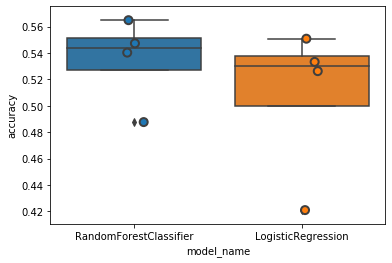

model_name
LogisticRegression        0.507895
RandomForestClassifier    0.535088
Name: accuracy, dtype: float64


In [48]:
#%matplotlib qt
models = [
    RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, min_samples_leaf=12, min_samples_split=3, n_estimators=100, bootstrap='False'),
    LogisticRegression(random_state=1, multi_class='ovr', solver='newton-cg', C=1.0)
]
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

print(cv_df.groupby('model_name').accuracy.mean())


## Feature Importance and Selection with RF and Log Reg

### Feature Importance / Selection with Random Forest

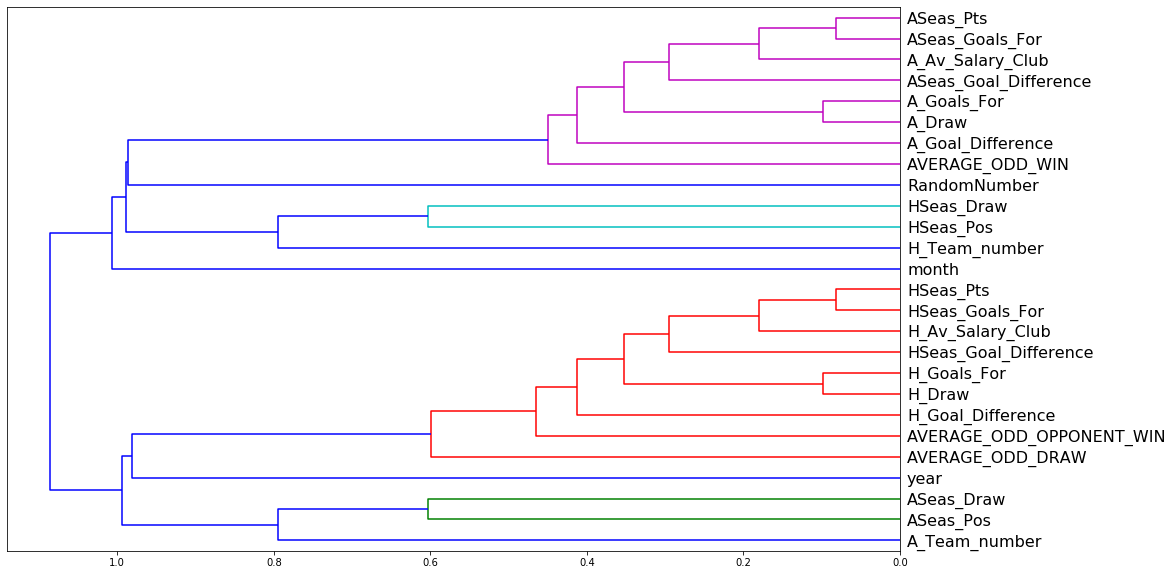

In [49]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns,
    orientation='left', leaf_font_size=16)
plt.show()

In [50]:
cm = pd.crosstab(clf.predict(X_train), y_train)
cm


outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,182,63,55
1.0,21,51,8
2.0,130,176,454


In [51]:
fi = pd.DataFrame({'Feature': list(X_train.columns),
                   'Importance': clf.feature_importances_}).\
                    sort_values('Importance', ascending = True)

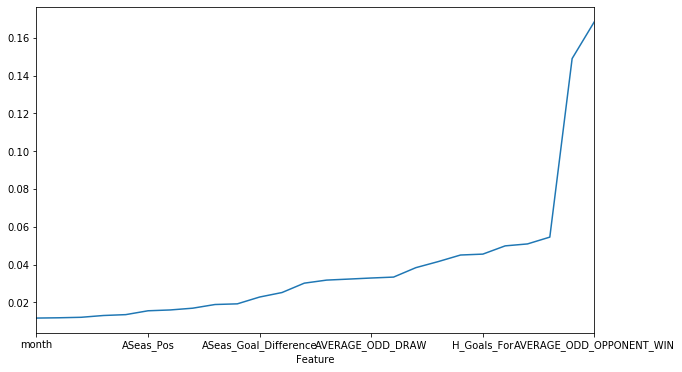

In [52]:
fi.plot('Feature', 'Importance', figsize=(10,6), legend=False);

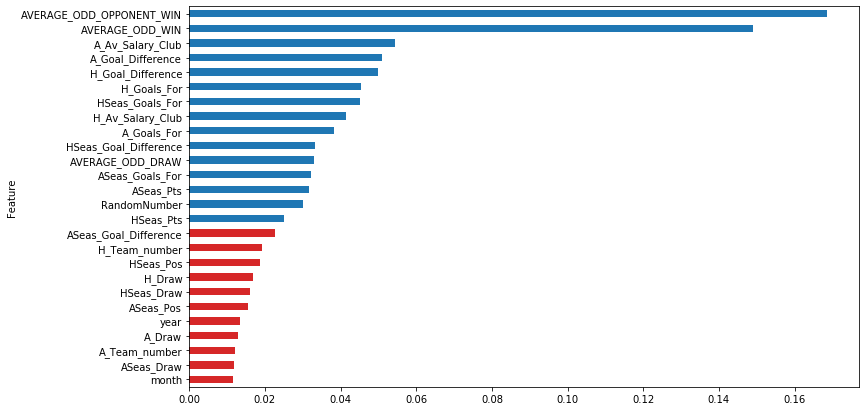

In [53]:
fi_plot = fi.plot('Feature','Importance', 'barh', figsize=(12,7), legend=False, color=['C3', 'C3','C3', 'C3', 'C3', 'C3', 'C3','C3', 'C3', 'C3', 'C3', 'C0', 'C0', 'C0', 'C0','C0', 'C0', 'C0', 'C0', 'C0', 'C0','C0', 'C0', 'C0', 'C0', 'C0'])
#labels = [item.get_text() for item in fi_plot.get_yticklabels()]
#labels[23] = 'Odds Away Win'
#labels[22] = 'Odds Home Win'
#labels[21] = 'Odds Draw'
#labels[20] = 'Away Salary'
#labels[19] = 'Home Total Goals For'
#labels[18] = 'Home Last Season Goals Difference'
#labels[17] = 'Home Salary'
#labels[16] = 'Home Last Season Goals For'
#labels[15] = 'Home Total Goals Difference'
#labels[14] = 'Away Last Season Goals For'
#labels[13] = 'Away Total Goals Difference'
#labels[12] = 'Random Number'
#labels[11] = 'Away Total Goals For'
#labels[10] = 'Home Last Season Points'
#labels[9] = 'Away Last Season Goals Difference'
#labels[8] = 'Away Season Points'
#labels[7] = 'Home Team Number'
#labels[6] = 'Home Team Total Draws'
#labels[5] = 'Away Team Total Draws'
#labels[4] = 'Away Team Number'
#labels[3] = 'Home Last Season Position'
#labels[2] = 'Away Last Season Position'
#labels[1] = 'Away Last Season Draw'
#labels[0] = 'Away Last Season Draw'
#fi_plot.set_yticklabels(labels)


In [54]:
fi

,Feature,Importance
24,month,0.011665
1,ASeas_Draw,0.011817
10,A_Team_number,0.012074
12,A_Draw,0.013021
23,year,0.013483
0,ASeas_Pos,0.015522
6,HSeas_Draw,0.015962
17,H_Draw,0.016891
5,HSeas_Pos,0.018837
15,H_Team_number,0.019190


In [55]:
to_keep = fi[fi.Importance>0.030].Feature
to_keep

25                RandomNumber
4                    ASeas_Pts
2              ASeas_Goals_For
21            AVERAGE_ODD_DRAW
8        HSeas_Goal_Difference
13                 A_Goals_For
16            H_Av_Salary_Club
7              HSeas_Goals_For
18                 H_Goals_For
19           H_Goal_Difference
14           A_Goal_Difference
11            A_Av_Salary_Club
20             AVERAGE_ODD_WIN
22    AVERAGE_ODD_OPPONENT_WIN
Name: Feature, dtype: object

In [56]:
X_train_keep = X_train[to_keep].copy()#.drop(['RandomNumber'], axis=1)
X_valid_keep = X_valid[to_keep].copy()#.drop(['RandomNumber'], axis=1)
X_test_keep = X_test[to_keep].copy()#.drop(['RandomNumber'], axis=1)


In [57]:
X_train_keep.head()

,RandomNumber,ASeas_Pts,ASeas_Goals_For,AVERAGE_ODD_DRAW,HSeas_Goal_Difference,A_Goals_For,H_Av_Salary_Club,HSeas_Goals_For,H_Goals_For,H_Goal_Difference,A_Goal_Difference,A_Av_Salary_Club,AVERAGE_ODD_WIN,AVERAGE_ODD_OPPONENT_WIN
0,393,0,0,3.5,-2,240,3.25,48,1357,46,-137,1.78,1.73,5.00
1,1374,56,46,4.0,41,306,5.02,73,1770,768,-77,1.47,1.40,10.00
2,1864,38,31,3.1,-9,612,2.71,46,623,-95,-292,1.14,2.00,2.70
3,1862,38,31,3.5,0,1117,1.99,0,201,-64,-69,1.30,1.91,4.00
4,1719,48,47,3.1,0,425,0.65,0,365,-145,-139,2.76,2.60,2.88


In [58]:
dtrain_keep = xgb.DMatrix(X_train_keep, label=y_train)
dvalid_keep = xgb.DMatrix(X_valid_keep, label=y_valid)
dtest_keep = xgb.DMatrix(X_test_keep, label=y_test)

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [59]:
#df_19B20A_output = df_19B20A_output[to_keep].copy().drop(['RandomNumber'], axis=1)

In [60]:
df_19B20A_output.head()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
0,0,0,0,0,0,2,7,89,67,97,19,0.65,92,365,-145,14,4.86,262,1774,728,1.12,8.5,21.00,2019,8,1746
1,1,2,95,72,98,10,7,52,-3,52,15,5.99,196,1374,399,28,3.19,228,1064,-205,13.00,6.0,1.24,2019,8,1389
2,16,12,45,-20,39,15,7,45,-23,40,21,2.67,214,937,-150,5,1.60,44,190,-107,2.70,3.2,2.75,2019,8,728
3,0,0,0,0,0,4,2,67,28,71,2,1.30,275,1117,-69,25,3.52,257,1547,241,1.29,5.5,10.00,2019,8,1179
4,17,9,35,-25,36,11,8,52,-7,50,4,1.70,22,69,-45,26,1.78,51,240,-137,1.95,3.4,4.20,2019,8,1025


In [61]:
d19B20A_keep = xgb.DMatrix(df_19B20A_output, label=y_19B20A_output)

In [62]:
d19B20A_keep = xgb.DMatrix(df_19B20A_output)

In [63]:
df_19B20A_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 26 columns):
ASeas_Pos                   380 non-null int64
ASeas_Draw                  380 non-null int64
ASeas_Goals_For             380 non-null int64
ASeas_Goal_Difference       380 non-null int64
ASeas_Pts                   380 non-null int64
HSeas_Pos                   380 non-null int64
HSeas_Draw                  380 non-null int64
HSeas_Goals_For             380 non-null int64
HSeas_Goal_Difference       380 non-null int64
HSeas_Pts                   380 non-null int64
A_Team_number               380 non-null int64
A_Av_Salary_Club            380 non-null float64
A_Draw                      380 non-null int64
A_Goals_For                 380 non-null int64
A_Goal_Difference           380 non-null int64
H_Team_number               380 non-null int64
H_Av_Salary_Club            380 non-null float64
H_Draw                      380 non-null int64
H_Goals_For                 380 non-null int6

In [64]:
forest = RandomForestClassifier(random_state=1)

n_estimators = [50, 100, 150]
max_depth = [1, 3, 5, 9, 12, 15]
min_samples_split = [1, 2, 3]
min_samples_leaf = [1, 6, 12, 15, 18, 24] 
bootstrap = ['False', 'True'] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              bootstrap = bootstrap)

gridF = GridSearchCV(forest, hyperF, verbose = 1, cv=4, n_jobs = -1)
bestF = gridF.fit(X_train_keep, y_train)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 648 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  2.4min finished


In [65]:
print(f'Best: {bestF.best_score_} using {bestF.best_params_}','\n')

Best: 0.5421052631578948 using {'bootstrap': 'False', 'max_depth': 9, 'min_samples_leaf': 24, 'min_samples_split': 2, 'n_estimators': 50} 



In [66]:
clf_keep = RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, min_samples_leaf=13, min_samples_split=6, n_estimators=150, bootstrap='False')
clf_keep.fit(X_train_keep, y_train)
print_score(clf_keep, X_train_keep, y_train, X_valid_keep, y_valid)



[0.954215025971334, 1.032370802417528, 0.6026315789473684, 0.5736842105263158]


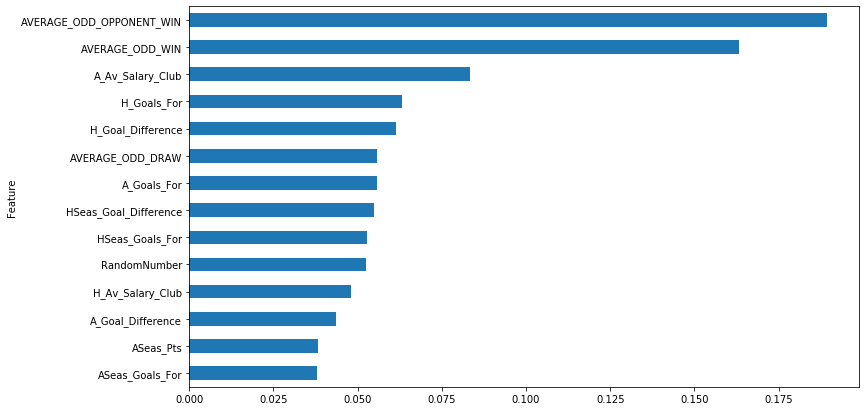

In [67]:
fi_keepvalid = pd.DataFrame({'Feature': list(X_valid_keep.columns),
                   'Importance': clf_keep.feature_importances_}).\
                    sort_values('Importance', ascending = True)
fi_plotvalid = fi_keepvalid.plot('Feature','Importance', 'barh', figsize=(12,7), legend=False, color=['C0', 'C0', 'C0', 'C0', 'C0','C0', 'C0', 'C0', 'C0', 'C0', 'C0'])
#labels = [item.get_text() for item in fi_plot.get_yticklabels()]
#labels[10] = 'Odds Away Win'
#labels[9] = 'Odds Home Win'
#labels[8] = 'Home Total Goals Difference'
#labels[7] = 'Away Salary'
#labels[6] = 'Home Total Goals For'
#labels[5] = 'Away Total Goals For'
#labels[4] = 'Home Last Season Goals Difference'
#labels[3] = 'Odds Draw'
#labels[2] = 'Away Last Season Goals For'
#labels[1] = 'Away Last Season Points'
#labels[0] = 'Home Salary'
#fi_plotvalid.set_yticklabels(labels)


In [68]:
X_valid_keep.head()

,RandomNumber,ASeas_Pts,ASeas_Goals_For,AVERAGE_ODD_DRAW,HSeas_Goal_Difference,A_Goals_For,H_Av_Salary_Club,HSeas_Goals_For,H_Goals_For,H_Goal_Difference,A_Goal_Difference,A_Av_Salary_Club,AVERAGE_ODD_WIN,AVERAGE_ODD_OPPONENT_WIN
0,1115,47,56,3.8,40,623,6.53,68,1989,1060,-95,2.71,1.57,6.00
1,719,0,0,3.5,-16,66,1.99,45,201,-64,-77,0.96,1.91,4.00
2,479,77,74,3.2,-8,1547,1.65,39,1249,14,241,3.52,3.80,2.05
3,766,49,44,3.2,0,1357,1.76,0,203,-124,46,3.25,2.30,3.20
4,1715,44,45,3.3,0,425,1.73,0,604,-174,-139,2.76,2.45,2.80


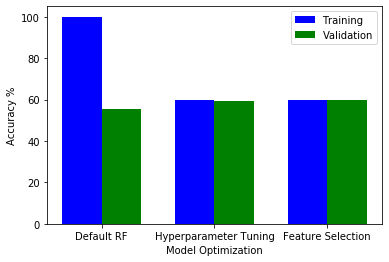

In [69]:
#%matplotlib qt
bar_width = 0.35
index = np.arange(3)
fig, ax = plt.subplots()
data_x = [0.0, 1.0, 2.0]
data_y = [100.0, 59.6, 59.7]
data_z = [55.5, 59.2, 59.7]
training = ax.bar(index, data_y, bar_width,
                label="Training", color='blue')
valid = ax.bar(index+bar_width, data_z,
                 bar_width, label="Validation", color='green')
ax.set_xlabel('Model Optimization')
ax.set_ylabel('Accuracy %')
ax.set_xticklabels(["Default RF", "Hyperparameter Tuning", "Feature Selection"])
ax.set_xticks(index + bar_width / 2)
ax.legend()
plt.show()


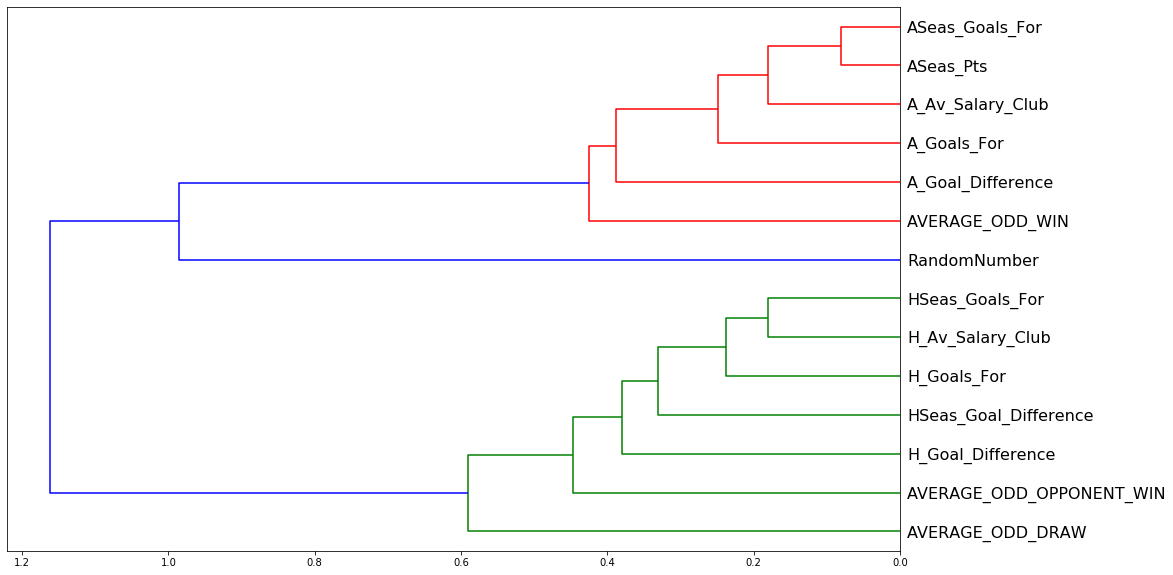

In [70]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_keep.columns,
    orientation='left', leaf_font_size=16)
plt.show()

### Confusion Matrix on Validation Data with Random Forest

In [71]:
print_score(clf_keep, X_train_keep, y_train, X_valid_keep, y_valid)
print_score(clf_keep, X_train_keep, y_train, X_test_keep, y_test)

print_score(clf, X_train, y_train, X_valid, y_valid)
print_score(clf, X_train, y_train, X_test, y_test)

[0.954215025971334, 1.032370802417528, 0.6026315789473684, 0.5736842105263158]
[0.954215025971334, 1.0526157893552615, 0.6026315789473684, 0.516]
[0.9403246919632545, 1.0234101919819987, 0.6026315789473684, 0.5842105263157895]
[0.9403246919632545, 1.0526157893552615, 0.6026315789473684, 0.528]


In [72]:
cm_validclf = pd.crosstab(clf.predict(X_valid), y_valid)
cm_validclf

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,61,9,18
1.0,5,4,6
2.0,62,58,157


In [73]:
cm_validclf_keep = pd.crosstab(clf_keep.predict(X_valid_keep), y_valid)
cm_validclf_keep

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,63,10,19
1.0,3,2,9
2.0,62,59,153


In [74]:
cm_testclf_keep = pd.crosstab(clf_keep.predict(X_test_keep), y_test)
cm_testclf_keep

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,37,14,14
1.0,4,5,6
2.0,38,45,87


In [75]:
cm_testclf = pd.crosstab(clf.predict(X_test), y_test)
cm_testclf

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,37,14,14
1.0,3,2,0
2.0,39,48,93


Text(0, 0.5, 'Predicted label')

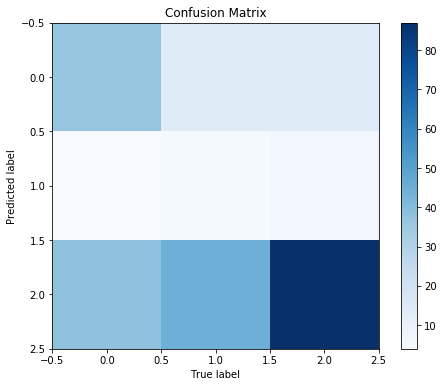

In [76]:
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(cm_testclf_keep, cmap=cmap)
plt.title('Confusion Matrix')
plt.grid(False)
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
    

### Confusion Matrix on Logistic Regression after Feature Selection

In [77]:
clf_LG_keep = LogisticRegression(random_state=1, multi_class='multinomial', solver='sag', C=1.0).fit(X_train_keep, y_train)
print(clf_LG_keep.score(X_train_keep, y_train))

predictions = clf_LG_keep.predict(X_valid_keep)
print(accuracy_score(y_valid, predictions))


0.5210526315789473
0.6052631578947368


/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [78]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'sag']
c_values = [100, 10, 1.0, 0.1, 0.01]
multi_class= ['multinomial', 'ovr']

# define grid search
grid = dict(solver=solvers,C=c_values, multi_class=multi_class)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_keep, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.526023 using {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.526023 (0.021980) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.511404 (0.023368) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
0.513743 (0.023073) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'sag'}
0.525731 (0.020898) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.522807 (0.020207) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
0.513743 (0.022760) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'sag'}
0.526023 (0.021980) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.513743 (0.027459) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
0.513450 (0.022482) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'sag'}
0.525731 (0.020898) with: {'C': 10, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.523977 (0.020526) with: {'C': 10, 'multi_class': 'ovr', 'solver': 'lbfgs'}
0.51

In [79]:
clf_LG_keep = LogisticRegression(random_state=1, multi_class='ovr', solver='newton-cg', C=1.0).fit(X_train_keep, y_train)
print(clf_LG_keep.score(X_train_keep, y_train))

predictions_keep = clf_LG_keep.predict(X_valid_keep)
print(accuracy_score(y_valid, predictions_keep))


0.5447368421052632
0.5684210526315789


In [80]:
cm_validLogReg = pd.crosstab(clf_LG.predict(X_valid), y_valid)
cm_validLogReg

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,55,9,14
1.0,13,8,17
2.0,60,54,150


In [81]:
cm_validLogReg_keep = pd.crosstab(clf_LG_keep.predict(X_valid_keep), y_valid)
cm_validLogReg_keep

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,65,11,25
1.0,7,3,8
2.0,56,57,148


## XGB

### XGB Parameter Tuning

In [82]:
param_init = {
    'silent': 1,  # logging mode - quiet default is 0
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset

In [83]:
bst_init = xgb.train(param_init, dtrain)
predstrain_init = bst_init.predict(dtrain)

bst_predstrain_init = np.asarray([np.argmax(line) for line in predstrain_init])
print(precision_score(y_train, bst_predstrain_init, average='macro'))
print(accuracy_score(y_train, bst_predstrain_init))


0.8687013865622952
0.8570175438596491


In [84]:
predsvalid_init = bst_init.predict(dvalid)

bst_predsvalid_init = np.asarray([np.argmax(line) for line in predsvalid_init])
print(precision_score(y_valid, bst_predsvalid_init, average='macro'))
print(accuracy_score(y_valid, bst_predsvalid_init))


0.46206701881909923
0.5368421052631579


In [ ]:
xgbcl = xgb.XGBClassifier(objective='multi:softprob',num_class=3)
param_grid = {
     "eta"    : [0.01, 0.04, 0.08, 0.12, 0.13, 0.14, 0.16, 0.2] ,
     "max_depth"        : [ 1, 2, 3, 4, 5, 6, 7],
     "min_child_weight" : [ 1, 3, 5, 7, 9, 10, 11, 13, 15 ],
     "gamma"            : [ 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
     "colsample_bytree" : [0.7, 0.8, 0.9, 1.0]
     }

grid_search = GridSearchCV(estimator=xgbcl,
                    param_grid=param_grid, n_jobs=-1,
                    scoring="accuracy",
                    cv=4)

grid_result = grid_search.fit(X_train_keep, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

In [ ]:
param = {
    'max_depth': 1,  # the maximum depth of each tree
    'eta': 0.01,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'min_child_weight': 15,  #
    'colsample_bytree': 0.9,  # 
    'gamma':0.75,
    'num_class': 3}  # the number of classes that exist in this datset

In [ ]:
xgbcl = xgb.XGBClassifier(objective='multi:softprob',num_class=3)
param_grid = {
     "eta"    : [0.01, 0.04, 0.08, 0.12, 0.13, 0.14, 0.16, 0.2] ,
     "max_depth"        : [3, 4],
     "min_child_weight" : [ 1, 3, 5, 7, 9, 10, 11, 13, 15 ],
     "gamma"            : [ 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
     "colsample_bytree" : [0.7, 0.8, 0.9, 1.0]
     }

grid_search = GridSearchCV(estimator=xgbcl,
                    param_grid=param_grid, n_jobs=-1,
                    scoring="accuracy",
                    cv=4)

grid_result = grid_search.fit(X_train_keep, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

In [ ]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.01,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'min_child_weight': 15,  #
    'colsample_bytree': 1.0,  # 
    'gamma':1.5,
    'num_class': 3}  # the number of classes that exist in this datset

In [ ]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.14,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'min_child_weight': 13,  #
    'colsample_bytree': 1,  # 
    'gamma':1,
    'num_class': 3}  # the number of classes that exist in this datset
num_round=10

In [ ]:
param = {
    'max_depth': 4,  # the maximum depth of each tree
    'eta': 0.13,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'min_child_weight': 10,  #
    'colsample_bytree': 1,  # 
    'gamma':1,
    'num_class': 3}  # the number of classes that exist in this datset
num_round=10

In [ ]:
bst = xgb.train(param, dtrain_keep, num_round)

predstrain = bst.predict(dtrain_keep)
bst_predstrain = np.asarray([np.argmax(line) for line in predstrain])
print(accuracy_score(y_train, bst_predstrain))

predsvalid = bst.predict(dvalid_keep)
bst_predsvalid = np.asarray([np.argmax(line) for line in predsvalid])
print(accuracy_score(y_valid, bst_predsvalid))

predstest = bst.predict(dtest_keep)
bst_predstest = np.asarray([np.argmax(line) for line in predstest])
print(accuracy_score(y_test, bst_predstest))

In [ ]:
predstest

In [ ]:
cm_trainxgb = pd.crosstab(bst_predstrain, y_train)
cm_trainxgb


In [ ]:
cm_validxgb = pd.crosstab(bst_predsvalid, y_valid)
cm_validxgb


In [ ]:
cm_testxgb = pd.crosstab(bst_predstest, y_test)
cm_testxgb


In [ ]:
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(cm_testxgb, cmap=cmap)
plt.title('Confusion Matrix')
plt.grid(False)
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')


In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(bst, height=0.8, ax=ax, grid=False, importance_type="gain", xlabel='Feature Importance', ylabel='Features', show_values=False, color=['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0'])
ax.set_yticklabels(['Home Last Season Goals Difference', 'Away Last Season Goals Difference', 'Home Salary', 'Away Total Goals For', 'Home Total Goals For', 'Away Last Season Goals For', 'Home Last Season Points', 'Away Total Goals Difference', 'Home Total Goals Difference', 'Away Last Season Points', 'Away Salary', 'Home Last Season Goals For', 'Odds Draw','Odds Away Win', 'Odds Home Win'])
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(bst, height=0.8, ax=ax, grid=False, importance_type="gain", xlabel='Feature Importance', ylabel='Features', show_values=False, color=['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1'])
ax.set_yticklabels(['Home Last Season Goals Difference', 'Away Last Season Goals Difference', 'Home Salary', 'Away Total Goals For', 'Home Total Goals For', 'Away Last Season Goals For', 'Home Last Season Points', 'Away Total Goals Difference', 'Home Total Goals Difference', 'Away Last Season Points', 'Away Salary', 'Home Last Season Goals For', 'Odds Draw','Odds Away Win', 'Odds Home Win'])
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(bst, height=0.8, ax=ax, grid=False, importance_type="gain", xlabel='Feature Importance', ylabel='Features', show_values=False, color=['C1', 'C1', 'C0', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C0', 'C1', 'C0', 'C0', 'C0'])
ax.set_yticklabels(['Home Last Season Goals Difference', 'Away Last Season Goals Difference', 'Home Salary', 'Away Total Goals For', 'Home Total Goals For', 'Away Last Season Goals For', 'Home Last Season Points', 'Away Total Goals Difference', 'Home Total Goals Difference', 'Away Last Season Points', 'Away Salary', 'Home Last Season Goals For', 'Odds Draw','Odds Away Win', 'Odds Home Win'])
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(bst, height=0.8, ax=ax, grid=False, importance_type="gain", xlabel='Feature Importance', ylabel='Features', show_values=False, color=['C0', 'C0', 'C1', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C1', 'C0', 'C0', 'C0', 'C0'])
ax.set_yticklabels(['Home Last Season Goals Difference', 'Away Last Season Goals Difference', 'Home Salary', 'Away Total Goals For', 'Home Total Goals For', 'Away Last Season Goals For', 'Home Last Season Points', 'Away Total Goals Difference', 'Home Total Goals Difference', 'Away Last Season Points', 'Away Salary', 'Home Last Season Goals For', 'Odds Draw','Odds Away Win', 'Odds Home Win'])
plt.show()


## Comparison against baseline methods

### RF, XGB and Log Reg

In [ ]:
print_score(clf, X_train, y_train, X_valid, y_valid)
print_score(clf, X_train, y_train, X_test, y_test)
print_score(clf_keep, X_train_keep, y_train, X_valid_keep, y_valid)
print_score(clf_keep, X_train_keep, y_train, X_test_keep, y_test)
print_score(clf_LG, X_train, y_train, X_valid, y_valid)
print_score(clf_LG, X_train, y_train, X_test, y_test)
print_score(clf_LG_keep, X_train_keep, y_train, X_valid_keep, y_valid)
print_score(clf_LG_keep, X_train_keep, y_train, X_test_keep, y_test)

In [ ]:
print(metrics.classification_report(y_test, bst_predstest, digits=3))


### Random, Home Team and Lowest Odds

In [ ]:
results = pd.DataFrame(bst_predstest)
results.rename(columns = {0:'XGB'}, inplace = True)
results.head()

In [ ]:
results['RandomNumber'] = np.random.randint(0, 3, results.shape[0])
results.head(300)

In [ ]:
print(metrics.classification_report(y_test, results['RandomNumber'], digits=3))



In [ ]:
cm_testrandom = pd.crosstab(results['RandomNumber'], y_test)
cm_testrandom

In [ ]:
results['HomeTeamWins'] = 2
results.head()
print(metrics.classification_report(y_test, results['HomeTeamWins'], digits=3))
cm_testhome = pd.crosstab(results['HomeTeamWins'], y_test)
cm_testhome

In [ ]:
results['Draw'] = 1
results.head()
print(metrics.classification_report(y_test, results['Draw'], digits=3))
cm_testhome = pd.crosstab(results['Draw'], y_test)
cm_testhome

In [ ]:
results['BestOdds'] = 0
results.BestOdds[(X_test_keep.AVERAGE_ODD_WIN < X_test_keep.AVERAGE_ODD_OPPONENT_WIN) & (X_test_keep.AVERAGE_ODD_WIN < X_test_keep.AVERAGE_ODD_DRAW)] = 2
results.BestOdds[(X_test_keep.AVERAGE_ODD_OPPONENT_WIN < X_test_keep.AVERAGE_ODD_WIN) & (X_test_keep.AVERAGE_ODD_OPPONENT_WIN < X_test_keep.AVERAGE_ODD_DRAW)] = 0
results.BestOdds[(X_test_keep.AVERAGE_ODD_DRAW < X_test_keep.AVERAGE_ODD_WIN) & (X_test_keep.AVERAGE_ODD_DRAW < X_test_keep.AVERAGE_ODD_OPPONENT_WIN)] = 1

print(metrics.classification_report(y_test, results['BestOdds'], digits=3))
cm_testbestodds = pd.crosstab(results['BestOdds'], y_test)
cm_testbestodds


In [ ]:
#%matplotlib qt
data_x = ['Soccer Science','Best Odds', 'Home Team', 'Random']
data_y = [56.4, 52.8, 42.8, 31.6]
plt.bar(data_x, data_y, color='blue')
plt.xlabel('Different Methods of Prediction')
plt.ylabel('Accuracy')
plt.ylim((20, 65))

In [ ]:
#%matplotlib qt
data_x = ['XGBoost','Random Forest', 'Logistic Regression']
data_y = [56.4, 53.6, 52]
plt.bar(data_x, data_y, color='blue')
plt.xlabel('Different Models')
plt.ylabel('Accuracy')
plt.ylim((40, 60))

In [ ]:
#%matplotlib qt
data_x = ['Soccer Science','Best Odds']
data_y = [56.4, 52.8]
plt.bar(data_x, data_y, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim((40, 60))

In [ ]:
#%matplotlib qt
data_x = ['Best Odds']
data_y = [-1879]
plt.bar(data_x, data_y, color=['C3'])
plt.xlabel('Predicting Outcomes')
plt.ylabel('Money Outcome ($)')
plt.ylim((-2000, 1500))

In [ ]:
#%matplotlib qt
data_x = ['Soccer Science','Best Odds']
data_y = [1211.0, -1879]
plt.bar(data_x, data_y, color=['C2', 'C3'])
plt.xlabel('Different Models')
plt.ylabel('Money Outcome')

### What if you bet 100 USD on each game for 2019 second half

In [ ]:
results['HomeOdds'] = X_test_keep.AVERAGE_ODD_WIN
results['AwayOdds'] = X_test_keep.AVERAGE_ODD_OPPONENT_WIN
results['DrawOdds'] = X_test.AVERAGE_ODD_DRAW
results['RF'] = clf_keep.predict(X_test_keep)
results['LogReg'] = clf_LG_keep.predict(X_test_keep)
results['Actual'] = y_test
results.head(300)

In [ ]:
bets_placed = len(results)*100
len(results)

In [ ]:
results['XGB_Outcome'] = 0
results.XGB_Outcome[(results.XGB == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.XGB_Outcome[(results.XGB == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.XGB_Outcome[(results.XGB == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_XGB = results['XGB_Outcome'].sum()
tot_winnings_XGB = winnings_XGB - bets_placed
tot_winnings_XGB

In [ ]:
results['RF_Outcome'] = 0
results.RF_Outcome[(results.RF == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.RF_Outcome[(results.RF == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.RF_Outcome[(results.RF == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_rf = results['RF_Outcome'].sum()
tot_winnings_rf = winnings_rf - bets_placed
tot_winnings_rf

In [ ]:
results['LogReg_Outcome'] = 0
results.LogReg_Outcome[(results.LogReg == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.LogReg_Outcome[(results.LogReg == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.LogReg_Outcome[(results.LogReg == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_logreg = results['LogReg_Outcome'].sum()
tot_winnings_logreg = winnings_logreg - bets_placed
tot_winnings_logreg


In [ ]:
results['Random_Outcome'] = 0
results.Random_Outcome[(results.RandomNumber == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Random_Outcome[(results.RandomNumber == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Random_Outcome[(results.RandomNumber == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_random = results['Random_Outcome'].sum()
tot_winnings_random = winnings_random - bets_placed
tot_winnings_random

In [ ]:
results['Home_Outcome'] = 0
results.Home_Outcome[(results.HomeTeamWins == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Home_Outcome[(results.HomeTeamWins == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Home_Outcome[(results.HomeTeamWins == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_home = results['Home_Outcome'].sum()
tot_winnings_home = winnings_home - bets_placed
tot_winnings_home

In [ ]:
results['Draw_Outcome'] = 1
results.Draw_Outcome[(results.Draw == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Draw_Outcome[(results.Draw == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Draw_Outcome[(results.Draw == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_draw = results['Draw_Outcome'].sum()
tot_winnings_draw = winnings_draw - bets_placed
tot_winnings_draw

In [ ]:
results['Odds_Outcome'] = 0
results.Odds_Outcome[(results.BestOdds == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Odds_Outcome[(results.BestOdds == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Odds_Outcome[(results.BestOdds == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_odds = results['Odds_Outcome'].sum()
tot_winnings_odds = winnings_odds - bets_placed
tot_winnings_odds

## Outputs for Web Application

In [ ]:
filename = 'df_19B20A.csv'
df_19B20A_output.to_csv(filename)

In [ ]:
df_19B20A_output.info()

In [ ]:
home_team = 5.02
away_team = 6.53
df_19B20A_output.AVERAGE_ODD_DRAW = 3.7
df_19B20A_output.AVERAGE_ODD_WIN = 1.83 
df_19B20A_output.AVERAGE_ODD_OPPONENT_WIN = 4.33

In [ ]:
prediction_input = df_19B20A_output[(df_19B20A_output.A_Av_Salary_Club==away_team) & (df_19B20A_output.H_Av_Salary_Club==home_team)]
prediction_input



In [ ]:
dprediction_input = xgb.DMatrix(prediction_input)

In [ ]:
preds_SS = bst.predict(dprediction_input)
print(preds_SS)
prediction = np.asarray([np.argmax(line) for line in preds_SS])
print(prediction)


In [ ]:
pickle.dump(bst, open("finalized_model.pickle.dat", "wb"))